# Decomposition of HDsEMG signals from tattoo

In [1]:
import numpy as np

%load_ext autoreload
%autoreload 2

import logging
import os

import pandas as pd
import torch
import seaborn as sns
from scipy import io as sio

import emgkit

logging.basicConfig(level=logging.INFO)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

FS = 2000
SEED = 42
DATA_PATH = os.path.join("data", "tattoo", "BeSiVi20231103180825.mat")

INFO:root:Using CUDA version


Load the signal, filter it and plot the power spectrum.

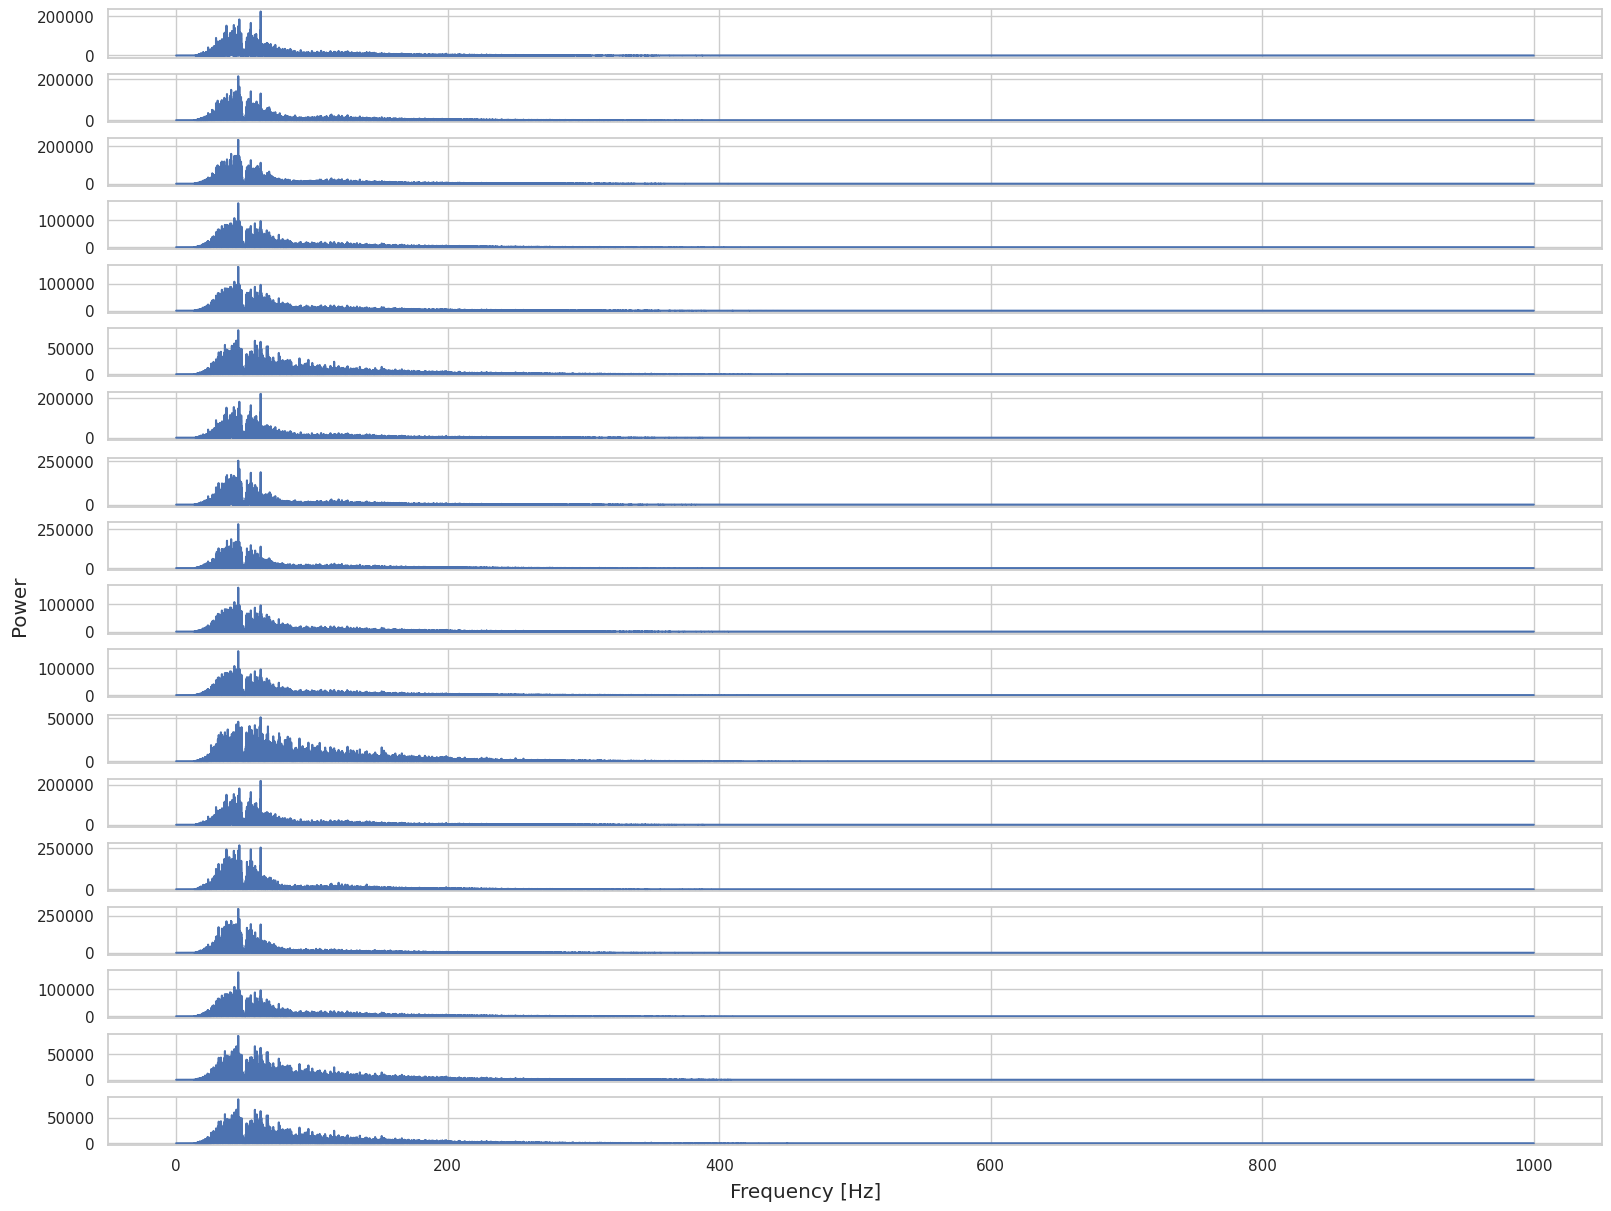

In [2]:
data = sio.loadmat(DATA_PATH)
emg = data["Data"]
emg = pd.DataFrame(
    data=emg,
    index=np.arange(emg.shape[0]) / FS,
    columns=[f"Ch{i}" for i in range(emg.shape[1])],
)

emg = emg.drop(
    columns=[
        "Ch0",
        "Ch1",
        "Ch8",
        "Ch9",
        "Ch16",
        "Ch17",
        "Ch24",
        "Ch25",
        "Ch26",
        "Ch27",
        "Ch28",
        "Ch29",
        "Ch30",
        "Ch31",
        "Ch32",
        "Ch33",
        "Ch34",
        "Ch35",
        "Ch36",
        "Ch37",
    ]
)
sig_len_s = emg.shape[0] / FS

# Filter
emg = emgkit.preprocessing.bandstop_filter(emg, low_cut=49, high_cut=51, fs=FS)
emg = emgkit.preprocessing.bandpass_filter(emg, low_cut=20, high_cut=500, fs=FS)

power_spectrum = emgkit.utils.power_spectrum(emg, FS)
emgkit.plotting.plot_signal(
    power_spectrum, x_label="Frequency [Hz]", y_label="Power", fig_size=(16, 12)
)

Plot filtered signal.

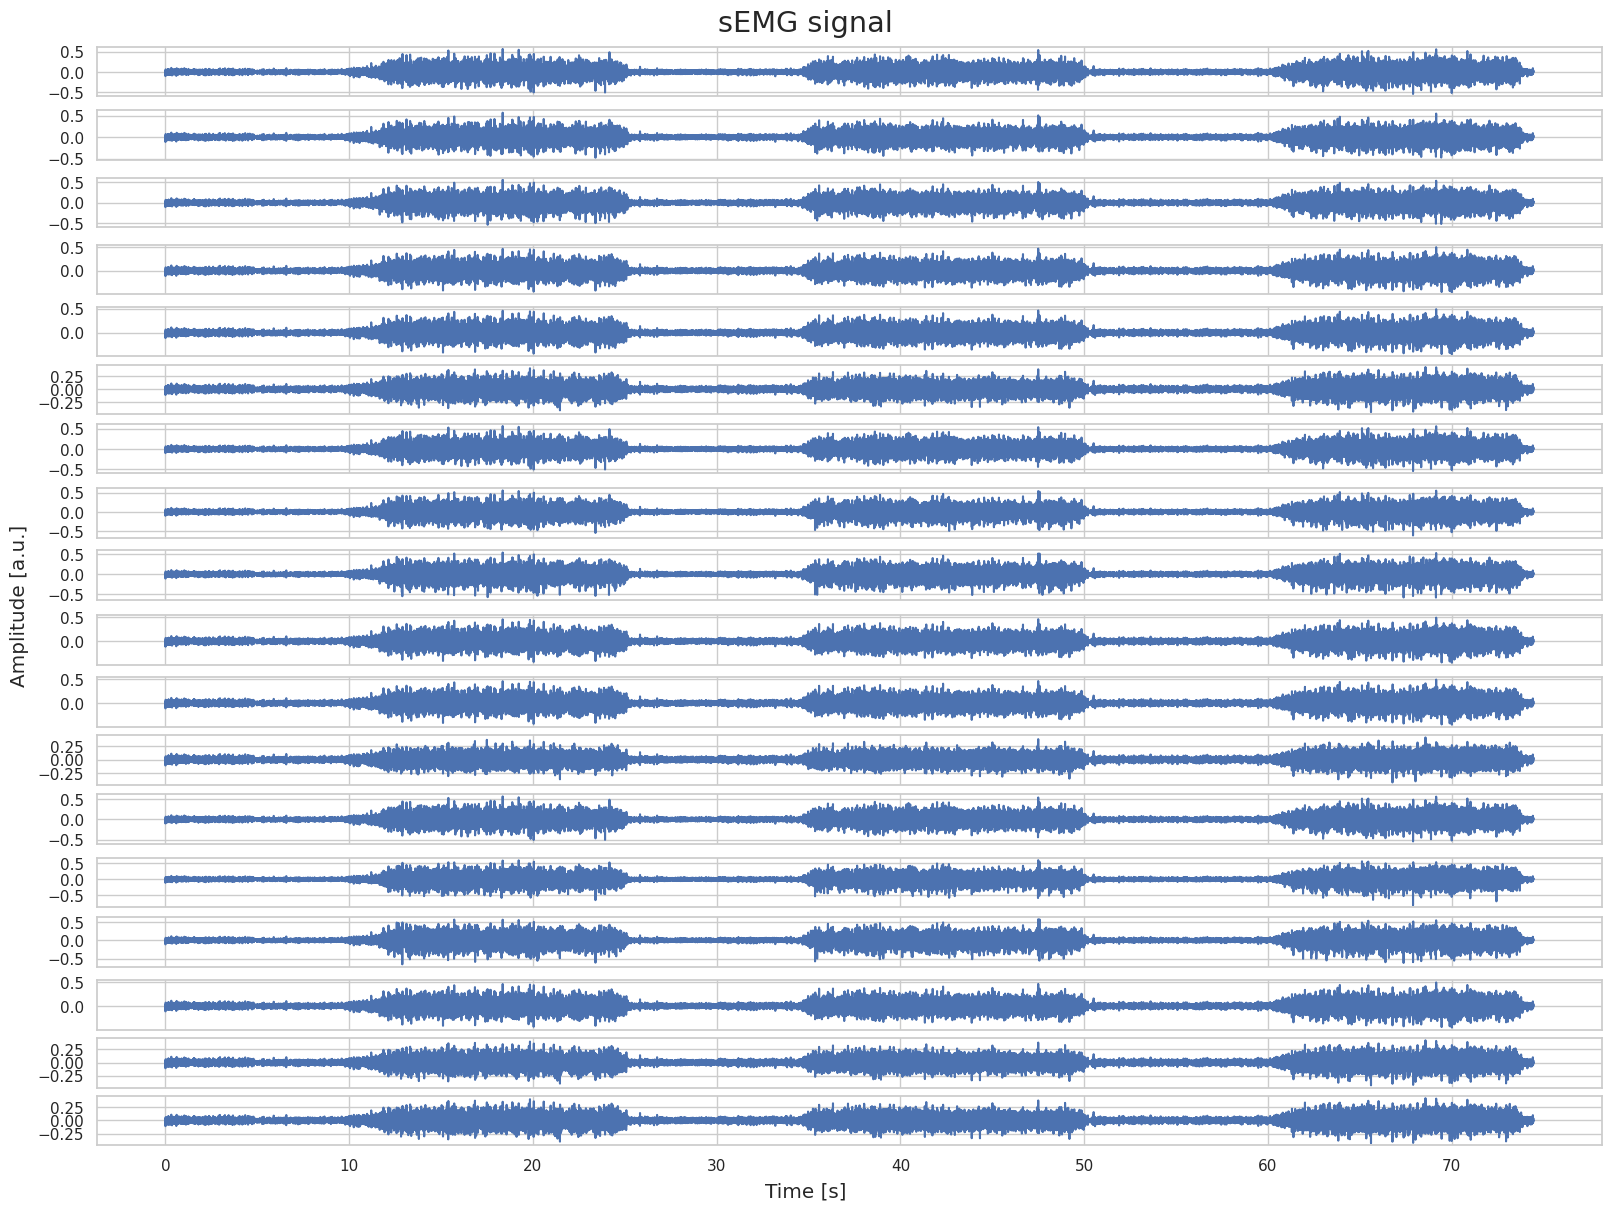

In [3]:
emgkit.plotting.plot_signal(emg, FS, title="sEMG signal", fig_size=(16, 12))

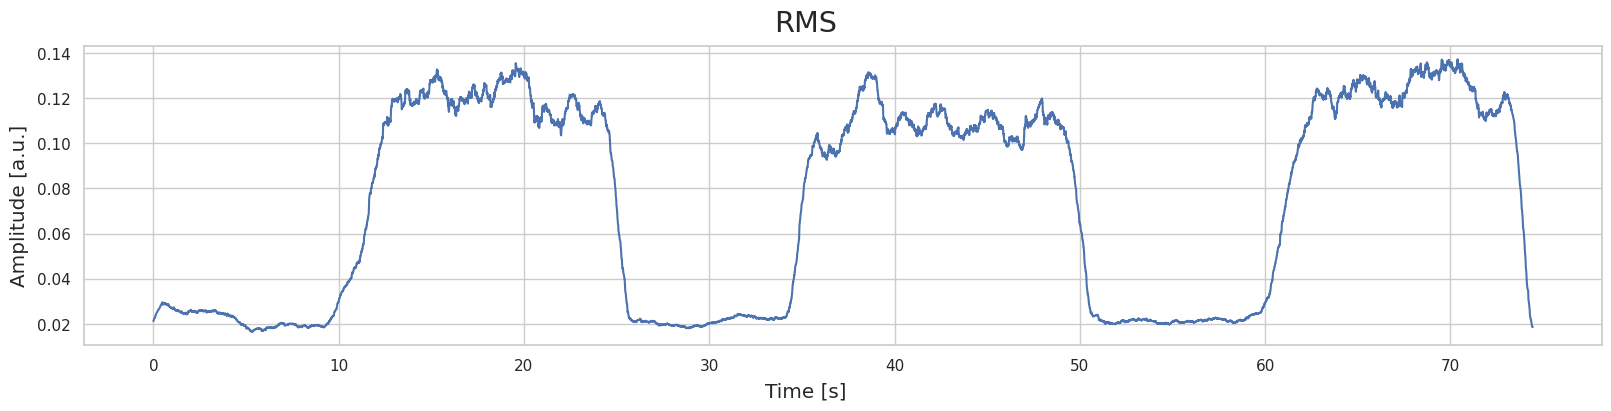

In [4]:
def apply_rms(sig, win_len):
    flt = np.ones(win_len) / win_len
    return np.apply_along_axis(
        lambda ch: np.sqrt(np.convolve(ch, flt, "same")), axis=0, arr=np.square(sig)
    )


emg_rms = apply_rms(emg, win_len=int(1 * FS))
emg_rms = np.mean(emg_rms, axis=1)  # take the mean across channels

emgkit.plotting.plot_signal(emg_rms, FS, title="RMS", fig_size=(16, 4))

In [5]:
def get_contraction_list(emg_, rms, th):
    n_ch = emg_.shape[1]

    # Fill non-contractions with NaNs
    emg_ma = emg_.copy()
    emg_ma[rms < th] = np.nan

    # Split each channel in chunks
    emg_chunks_tmp = []
    for i in range(n_ch):
        emg_chunks_tmp.append(
            [
                emg_ma[s, i]
                for s in np.ma.clump_unmasked(np.ma.masked_invalid(emg_ma[:, i]))
            ]
        )
    n_contr = len(emg_chunks_tmp[0])

    # Rebuild channels
    emg_chunks = []
    for i in range(n_contr):
        emg_chunks.append(np.vstack([emg_chunks_tmp[j][i] for j in range(n_ch)]).T)

    return emg_chunks


emg_contractions = get_contraction_list(emg, emg_rms, 0.08)

Instantiate the decomposition model and perform the MU extraction.

In [6]:
conv_bss = emgkit.decomposition.ConvBSS(
    fs=FS,
    n_mu_target=300,
    sil_th=0.75,
    device=device,
    seed=SEED,
)

for emg_contraction in emg_contractions:
    conv_bss.decompose_training(emg_contraction)

ics, spikes_t = conv_bss.decompose_inference(emg)
ext_sig_len_s = ics.shape[0] / FS

INFO:root:Number of channels before extension: 18
INFO:root:Number of channels after extension: 306


INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 26 iterations, the distance is: 7.707e-05.
INFO:root:CoV-ISI decreased from 68.81% to 65.79% after 1 steps.
INFO:root:CoV-ISI increased from 65.79% to 98.83% after 2 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 24 iterations, the distance is: 9.429e-05.
INFO:root:CoV-ISI decreased from 73.54% to 67.12% after 1 steps.
INFO:root:CoV-ISI increased from 67.12% to 77.70% after 2 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 37 iterations, the distance is: 8.154e-05.
INFO:root:CoV-ISI decreased from 82.94% to 80.11% after 1 steps.
INFO:root:CoV-ISI increased from 80.11% to 102.48% after 2 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 93 iterations, the distance is: 9.912e-05.
INFO:root:CoV-ISI decreased from 74.60% to 60.78% after 1 steps.
INFO:root:CoV-ISI increased from 60.78% to 66.48% after 2 steps.
INFO:root:----- IC 5 -----
INFO:root:FastICA converged after 70

Plot the ICs spike trains.

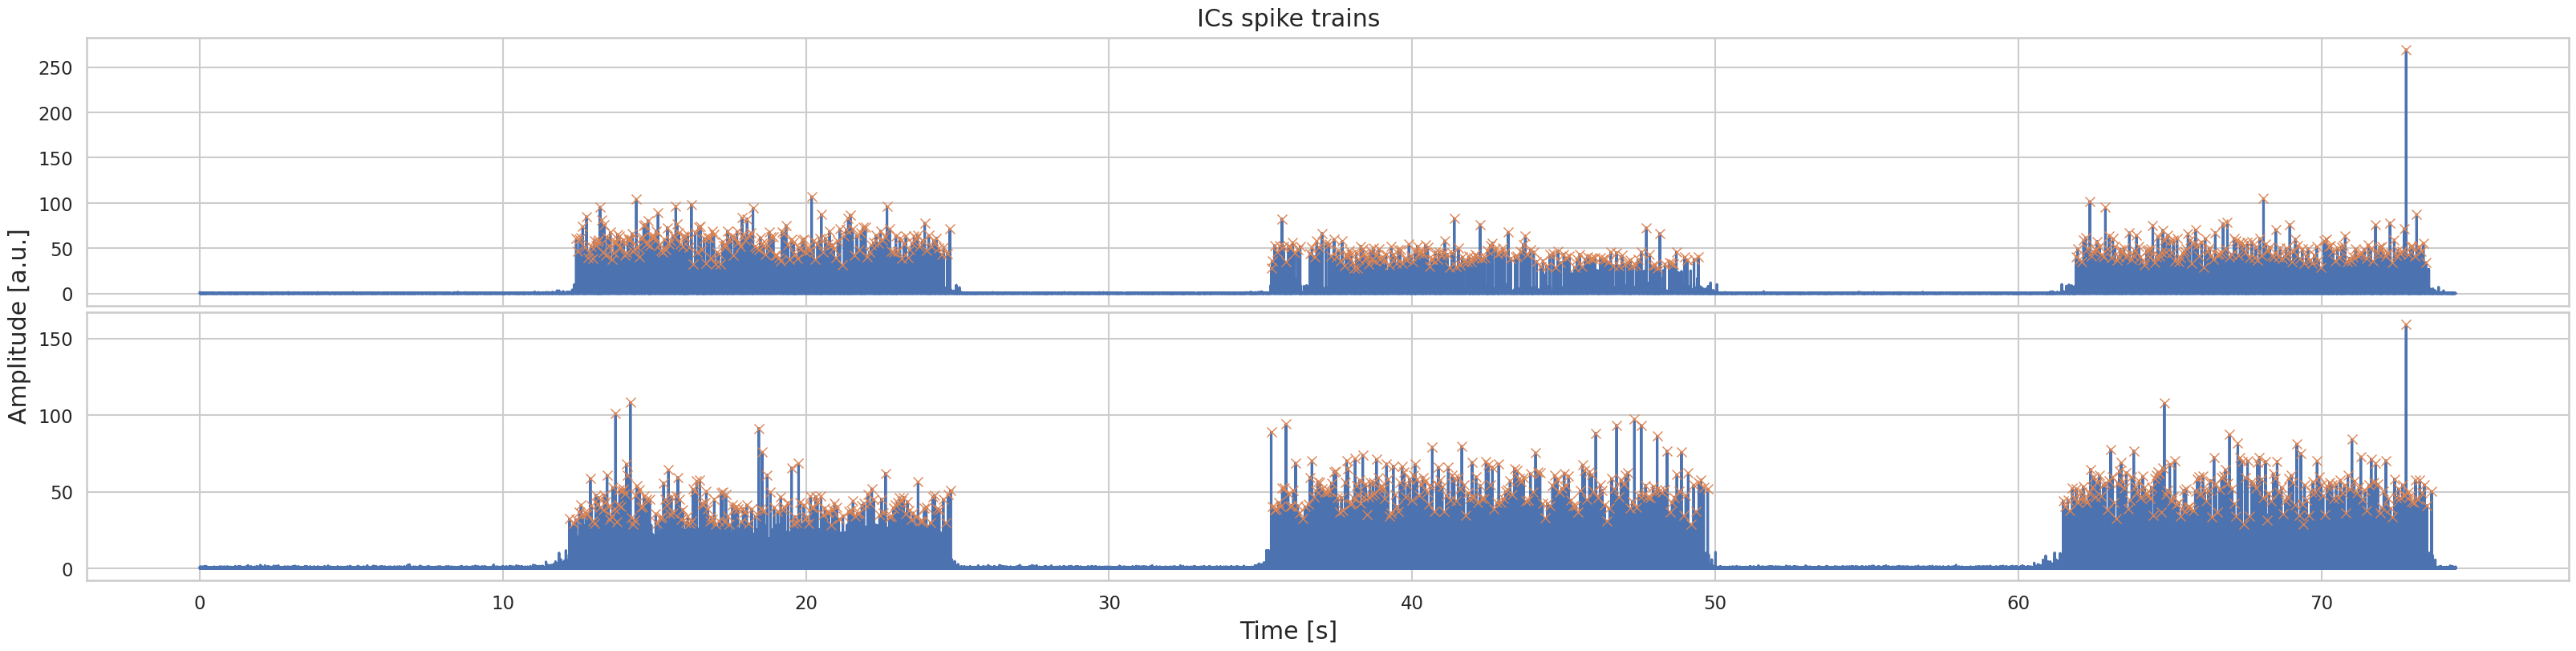

In [7]:
sns.set_context("talk")
emgkit.plotting.plot_ic_spikes(ics, spikes_t, fig_size=(32, 8))

Display the raster plot.

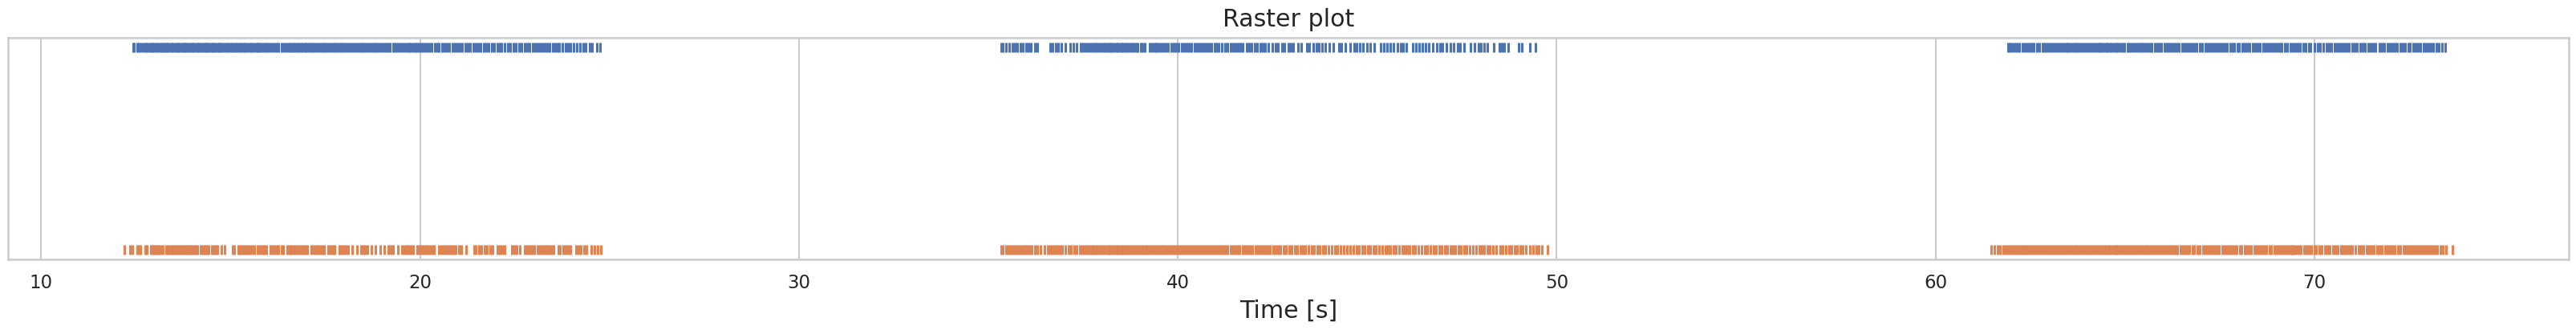

In [8]:
emgkit.plotting.raster_plot(spikes_t, fig_size=(32, 4))

Display the discharge rate.

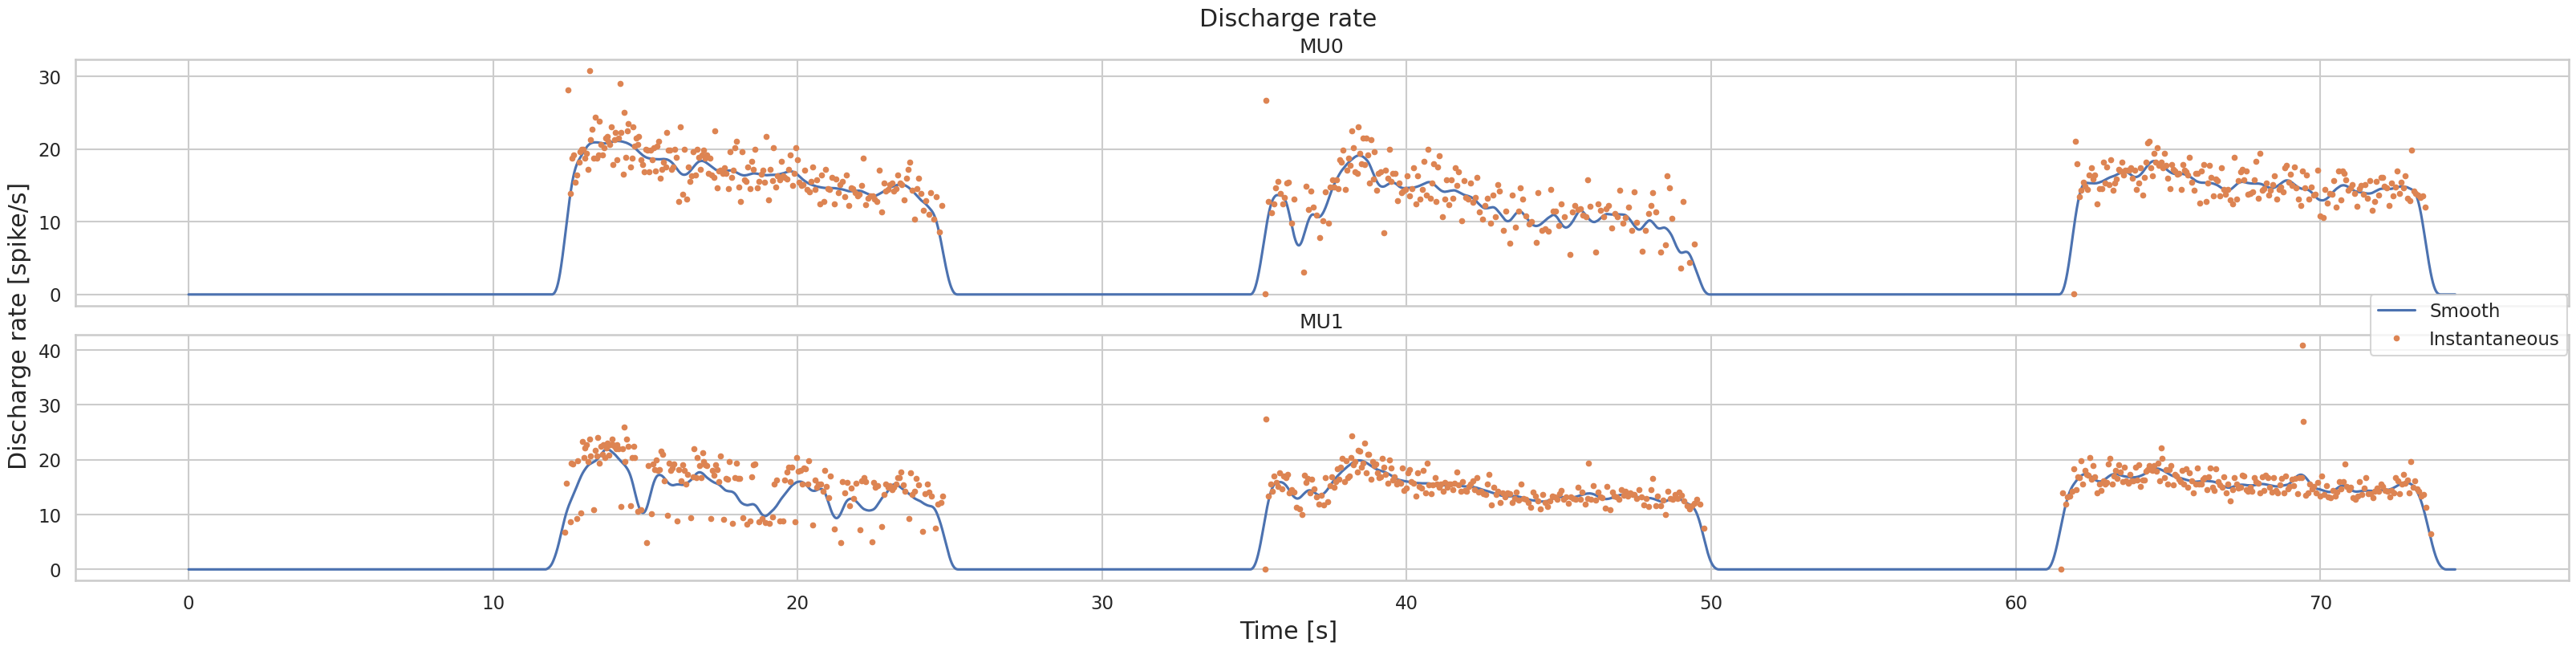

In [9]:
emgkit.plotting.plot_discharges(spikes_t, ext_sig_len_s, FS, fig_size=(32, 8))

Compute the waveforms and plot them.

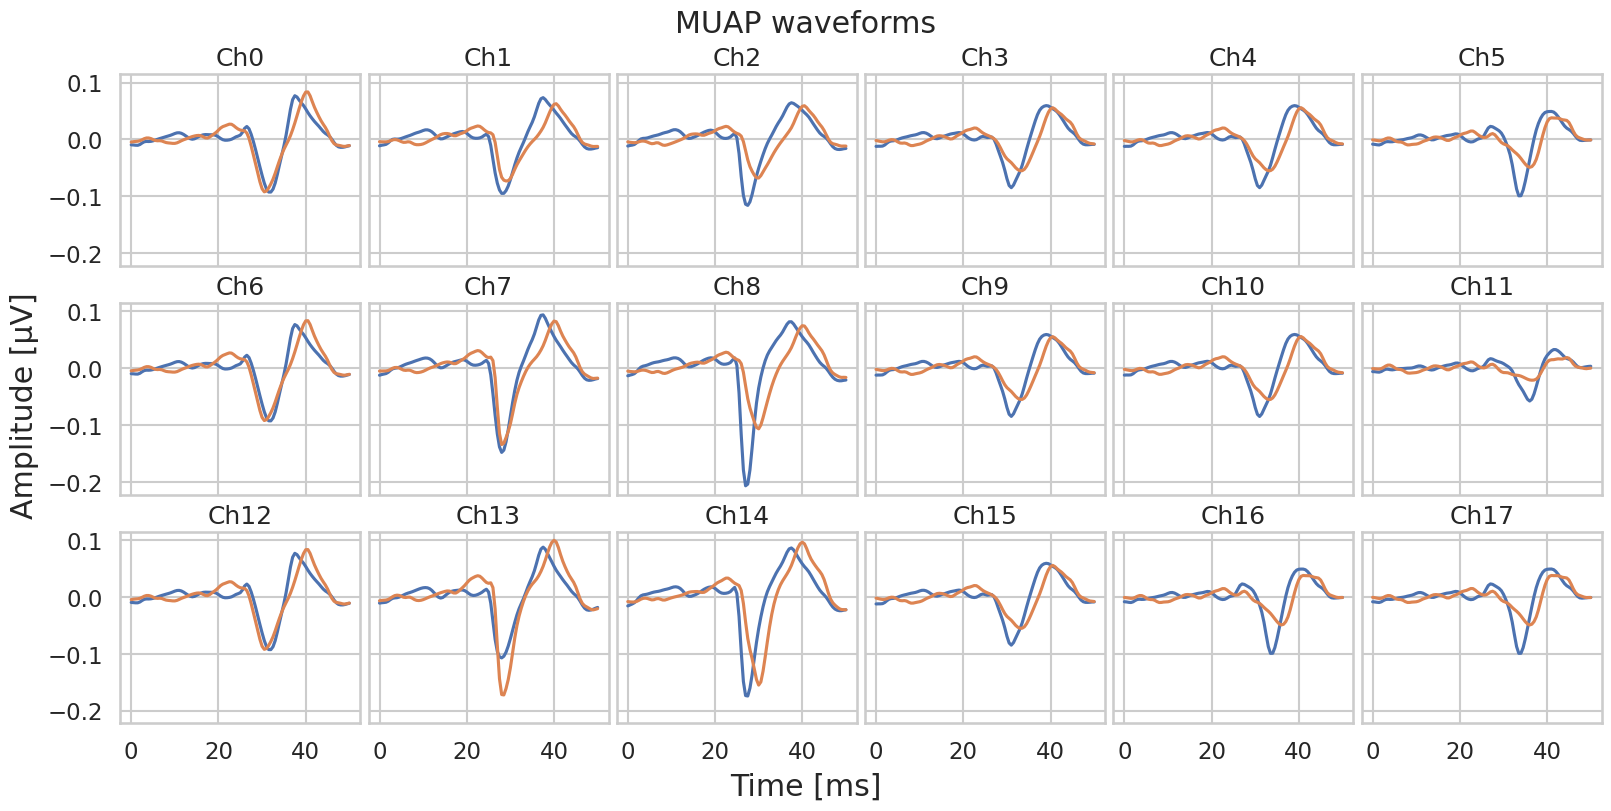

In [10]:
wfs = emgkit.utils.compute_waveforms(emg, spikes_t, wf_radius_ms=25.0, fs=FS)

emgkit.plotting.plot_waveforms(
    wfs, fs=FS, n_cols=6, y_label="Amplitude [\u03BCV]", fig_size=(16, 8)
)